# Azure Machine Learning Functional Overview

## End to End Solution

Microsoft Azure Machine Learning platform supports seamless, end-to-end AI/ML lifecycle management workflows: 

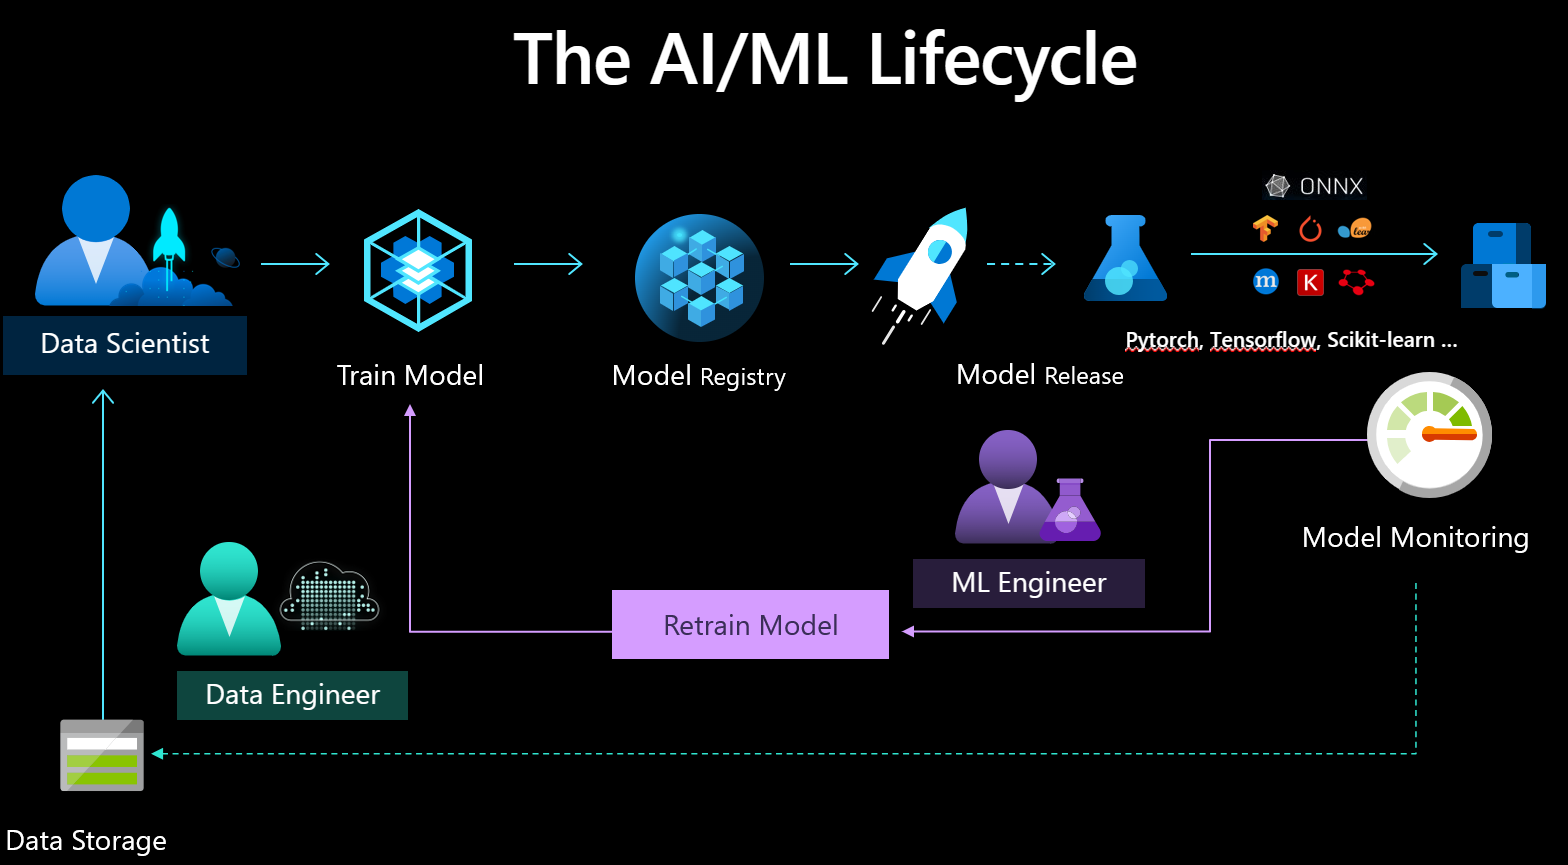

Azure ML offers tooling to support real-world enterprise lifecycle which includes:
1. Proof of Concept experimentation
2. Scaled training pipelines
3. Production-ready endpoint management

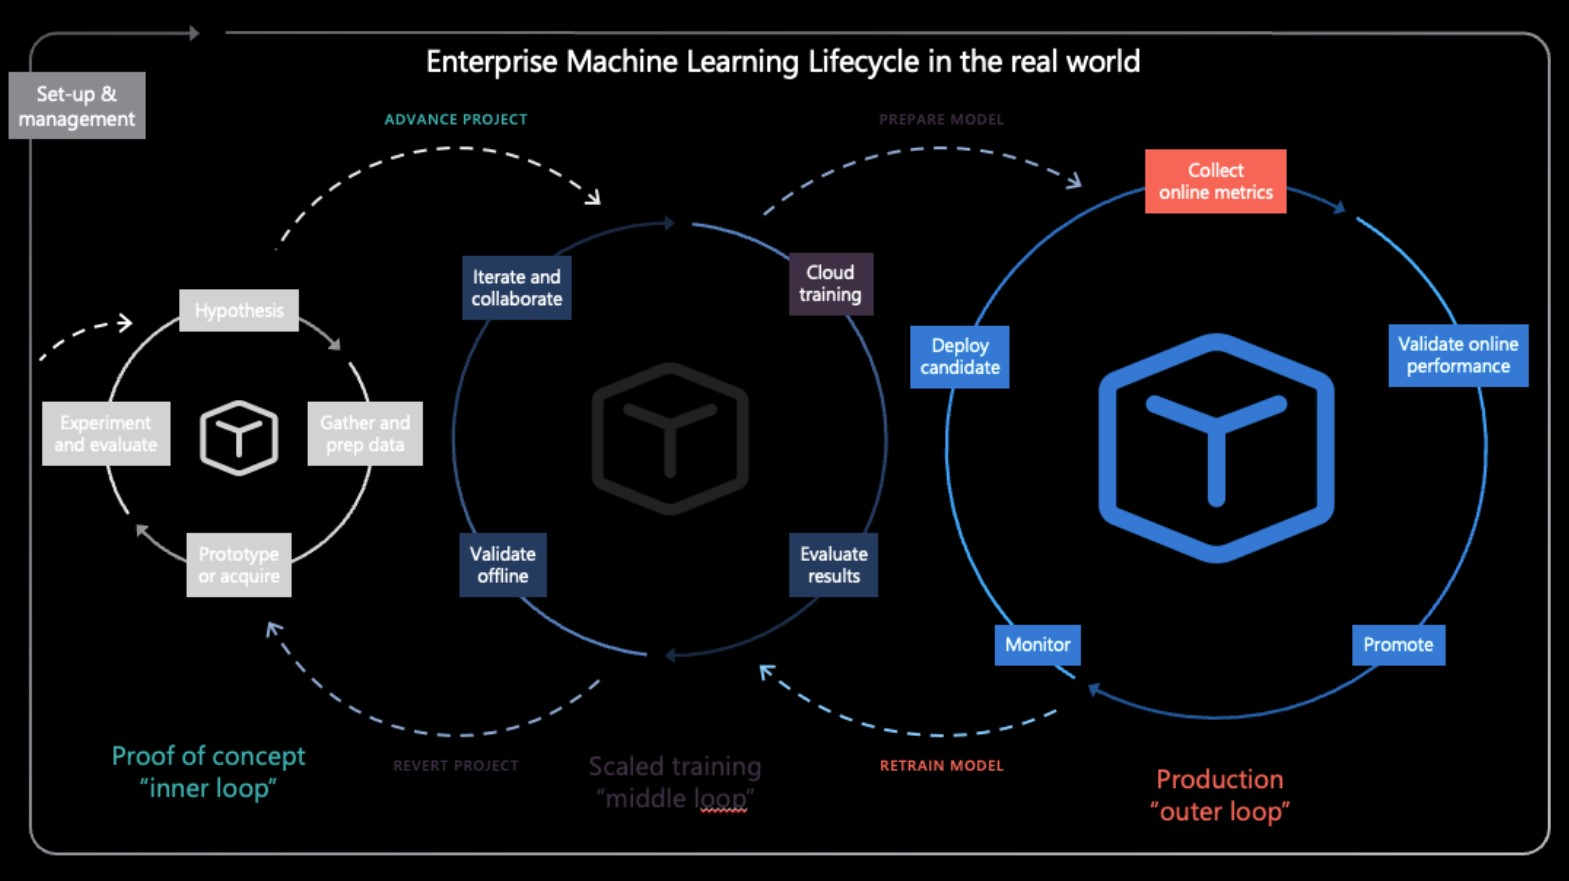

### Proof of Concept

Import local data into the Azure ML Platform workspace

In [ ]:
%%writefile dataimport.yml
$schema: https://azuremlschemas.azureedge.net/latest/data.schema.json
name: credit_cards
description: Data asset created from local file.
type: uri_file
path: data\default_of_credit_card_clients.csv

Overwriting dataimport.yml


In [ ]:
!az ml data create --file dataimport.yml 

{
  "creation_context": {
    "created_at": "2023-10-20T16:10:48.467901+00:00",
    "created_by": "Anton Slutsky",
    "created_by_type": "User",
    "last_modified_at": "2023-10-20T16:10:48.495694+00:00"
  },
  "description": "Data asset created from local file.",
  "id": "/subscriptions/781b03e7-6eb7-4506-bab8-cf3a0d89b1d4/resourceGroups/SandboxML/providers/Microsoft.MachineLearningServices/workspaces/quick-start-tutorial/data/default_of_credit_card_clients_example/versions/1",
  "name": "default_of_credit_card_clients_example",
  "path": "azureml://subscriptions/781b03e7-6eb7-4506-bab8-cf3a0d89b1d4/resourcegroups/SandboxML/workspaces/quick-start-tutorial/datastores/workspaceblobstore/paths/LocalUpload/4b1dfc4d12429b46389cabdf25b886a2/default_of_credit_card_clients.csv",
  "properties": {},
  "resourceGroup": "SandboxML",
  "tags": {},
  "type": "uri_file",
  "version": "1"
}


You can see the uploaded data by selecting **Data** on the left. You'll see the data is uploaded and a data asset is created:

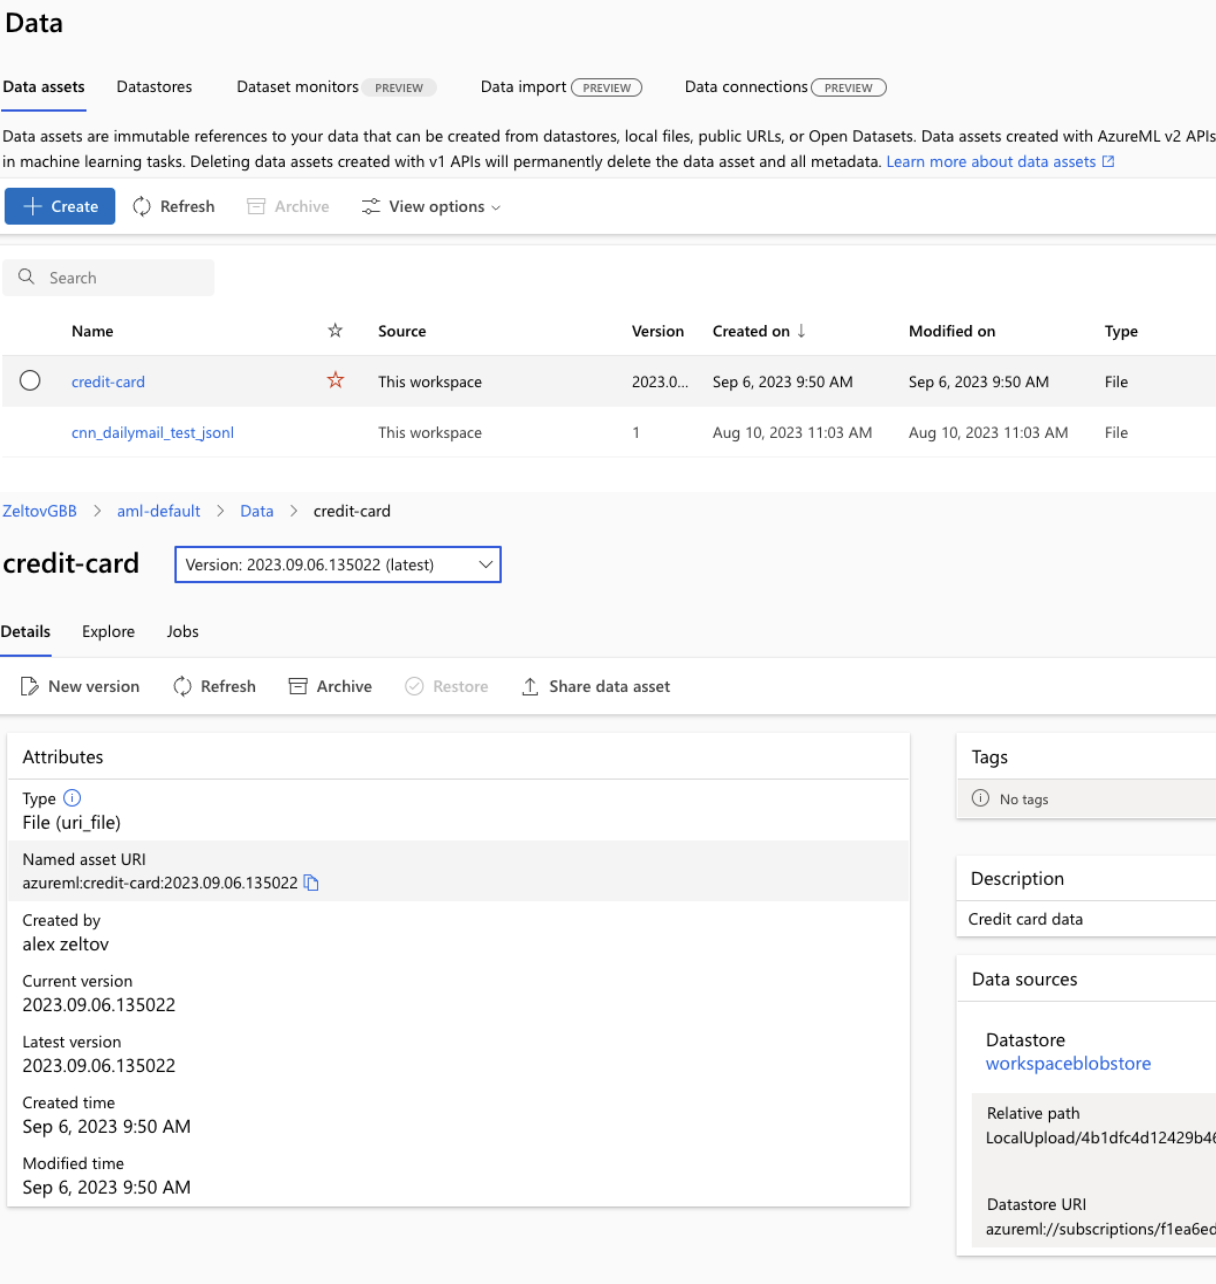

This data is named **credit-card**, and in the **Data assets** tab, we can see it in the **Name** column. This data uploaded to your workspace's default datastore named **workspaceblobstore**, seen in the **Data source** column. 

An Azure Machine Learning datastore is a *reference* to an *existing* storage account on Azure. A datastore offers these benefits:

1. A common and easy-to-use API, to interact with different storage types (Blob/Files/Azure Data Lake Storage) and authentication methods.
1. An easier way to discover useful datastores, when working as a team.
1. In your scripts, a way to hide connection information for credential-based data access (service principal/SAS/key).




## Access your data in a notebook

Pandas directly support URIs - this example shows how to read a CSV file from an Azure Machine Learning Datastore:

```
import pandas as pd

df = pd.read_csv("azureml://subscriptions/<subid>/resourcegroups/<rgname>/workspaces/<workspace_name>/datastores/<datastore_name>/paths/<folder>/<filename>.csv")
```

### Scaled Training

Example of a scalable cluster configuration

In [ ]:
%env CLUSTER_NAME cpu-cluster-test
!az ml compute create -n %CLUSTER_NAME% --type amlcompute \
    --min-instances 0 \
    --max-instances 4 \
    --size STANDARD_DS3_V2 \
    --idle-time-before-scale-down 180 \
    --tier Dedicated \
    --resource-group %RESOURCE_GROUP_NAME% \
    --workspace-name %WORKSPACE_NAME%

### CLI Job Configuration

Now create a job configuration file that references the <a href="./dependencies/conda.yml">conda.yml</a> to create a job and initialize execution.

In [ ]:
%%writefile dependencies/cli_job.yml
$schema: https://azuremlschemas.azureedge.net/latest/commandJob.schema.json
code: ../src
command: >-
  python main.py ### <---- main job driver
  --data ${{inputs.data}} ### <----- data to be used
  --test_train_ratio ${{inputs.test_train_ratio}}               ####
  --learning_rate ${{inputs.learning_rate}}                     #### <---- additional job parameters
  --registered_model_name ${{inputs.registered_model_name}}     ####
inputs:
  data: 
    type: uri_file
    path: azureml:credit-card_csv:2023.10.05.154542
  test_train_ratio: 0.2
  learning_rate: 0.25
  registered_model_name: credit_default_model
environment: 
  image: mcr.microsoft.com/azureml/openmpi3.1.2-ubuntu18.04:latest
  conda_file: conda.yml #### <--- CONDA.YML
compute: azureml:cpu-cluster #### <---- COMPUTE RESOURCE
display_name: sklearn-iris-example
experiment_name: sklearn-iris-example
description: Train a scikit-learn SVM on the Iris dataset.


Overwriting dependencies/cli_job.yml


Create the job

In [ ]:
!az ml job create -f dependencies\cli_job.yaml --query name -o tsv

Observe the job configuration and runtime information is now available in the Jobs user interface section of the platform workspace:

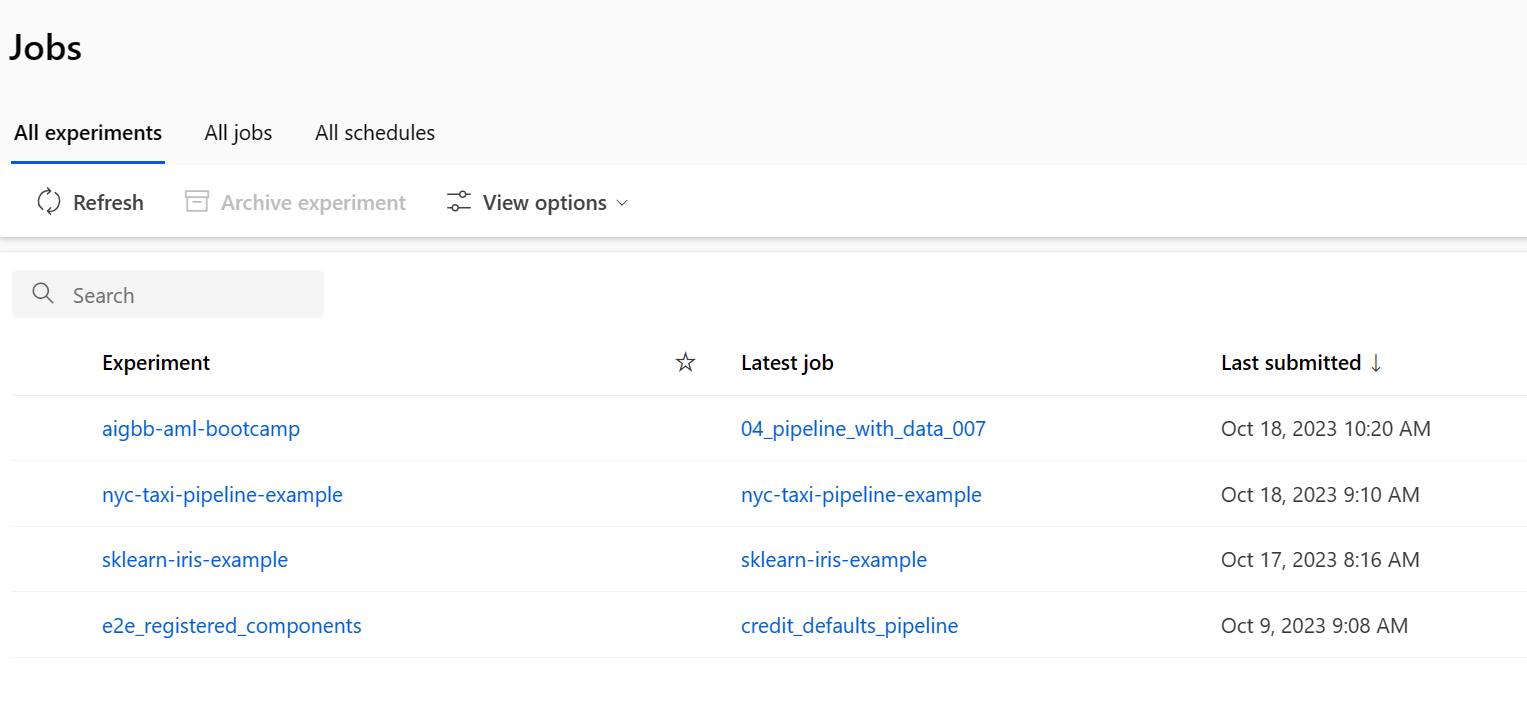

### Production Endpoint Management

### Model Registry

Trained models are managed through a Model Registry

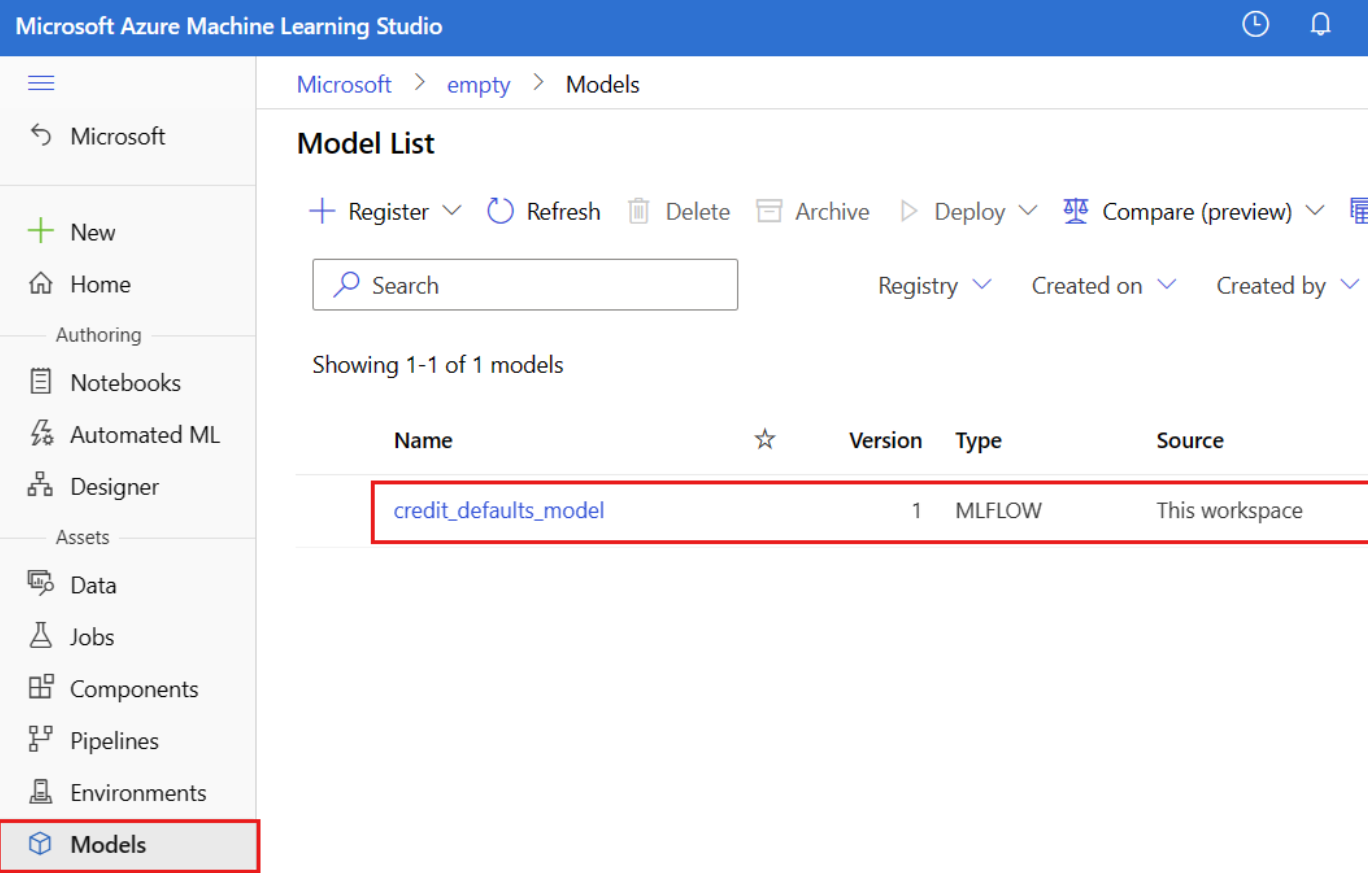

The following CLI command may be used to register a model trained by a job (above)

In [ ]:
%%writefile model.yml
$schema: https://azuremlschemas.azureedge.net/latest/model.schema.json
name: local-file-example
path: mlflow-model/model.pkl
description: Model created from local file.

In [ ]:
!az ml model create --file model.yml

## Function-specific Features

### Auto-ML

## Expert MLOps Support

## Administration and Security